In [1]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from glob import glob
from PIL import Image
from random import shuffle

In [3]:
def plot_scatter(col_x, col_y, lims):
    """Plots col_y against col_x."""
    corr = df_group[[col_x, col_y]].corr().loc[col_x, col_y]
    plt.plot(
        np.log10(df_group[col_x].values + 1 + np.random.random(df_group.shape[0]) * 0.4),
        np.log10(df_group[col_y].values + 1 + np.random.random(df_group.shape[0]) * 0.4),
        marker='o', linestyle='None', alpha=0.4)
    plt.axis('square')
    plt.xlim(lims)
    plt.ylim(lims)
    plt.title('{} vs {}; Correlation (in levels): {:.2f}'.format(col_y, col_x, corr))
    plt.xlabel('log({} + 1)'.format(col_x))
    plt.ylabel('log({} + 1)'.format(col_y))
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, '{}_vs_{}.pdf'.format(col_x, col_y)))
    plt.show()
    plt.close('all')

In [4]:
# census data
CEN_IN_DIR = 'data/Experiment0/census.csv'
# satellite derived data
SAT_IN_DIR = 'data/GoogleStaticMap/Pred/infer/annotations_pred.json'
# visual path
VIZ_DIR = 'data/GoogleStaticMap/Visual/infer/pred'
# output path
OUT_DIR = 'data/Experiment0/Output/'
# score cutoff
SCORE_CUTOFF = 0.6

In [5]:
# read census data frame
df_cen = pd.read_csv(CEN_IN_DIR, index_col='index')

In [6]:
# TODO: drop NA localities with census_download_log.csv

In [7]:
# read json annotations
with open(SAT_IN_DIR, 'r') as f:
    df_sat = json.load(f)
df_sat = [[ins['image_id_str'], ins['category_id'],
           ins['score'], ins['area']]
          for ins in df_sat]
df_sat = pd.DataFrame(
    df_sat, columns=['index', 'category_id', 'score', 'area'])
df_sat = df_sat.loc[df_sat['score'] > SCORE_CUTOFF, :]
df_sat.set_index('index', inplace=True)

In [8]:
df = pd.merge(df_cen, df_sat, how='left', on='index')
df.drop(columns=['lon', 'lat', 'lon_shift', 'lat_shift', 'category_id'], inplace=True)
df.set_index(['ent', 'mun', 'loc'], inplace=True)

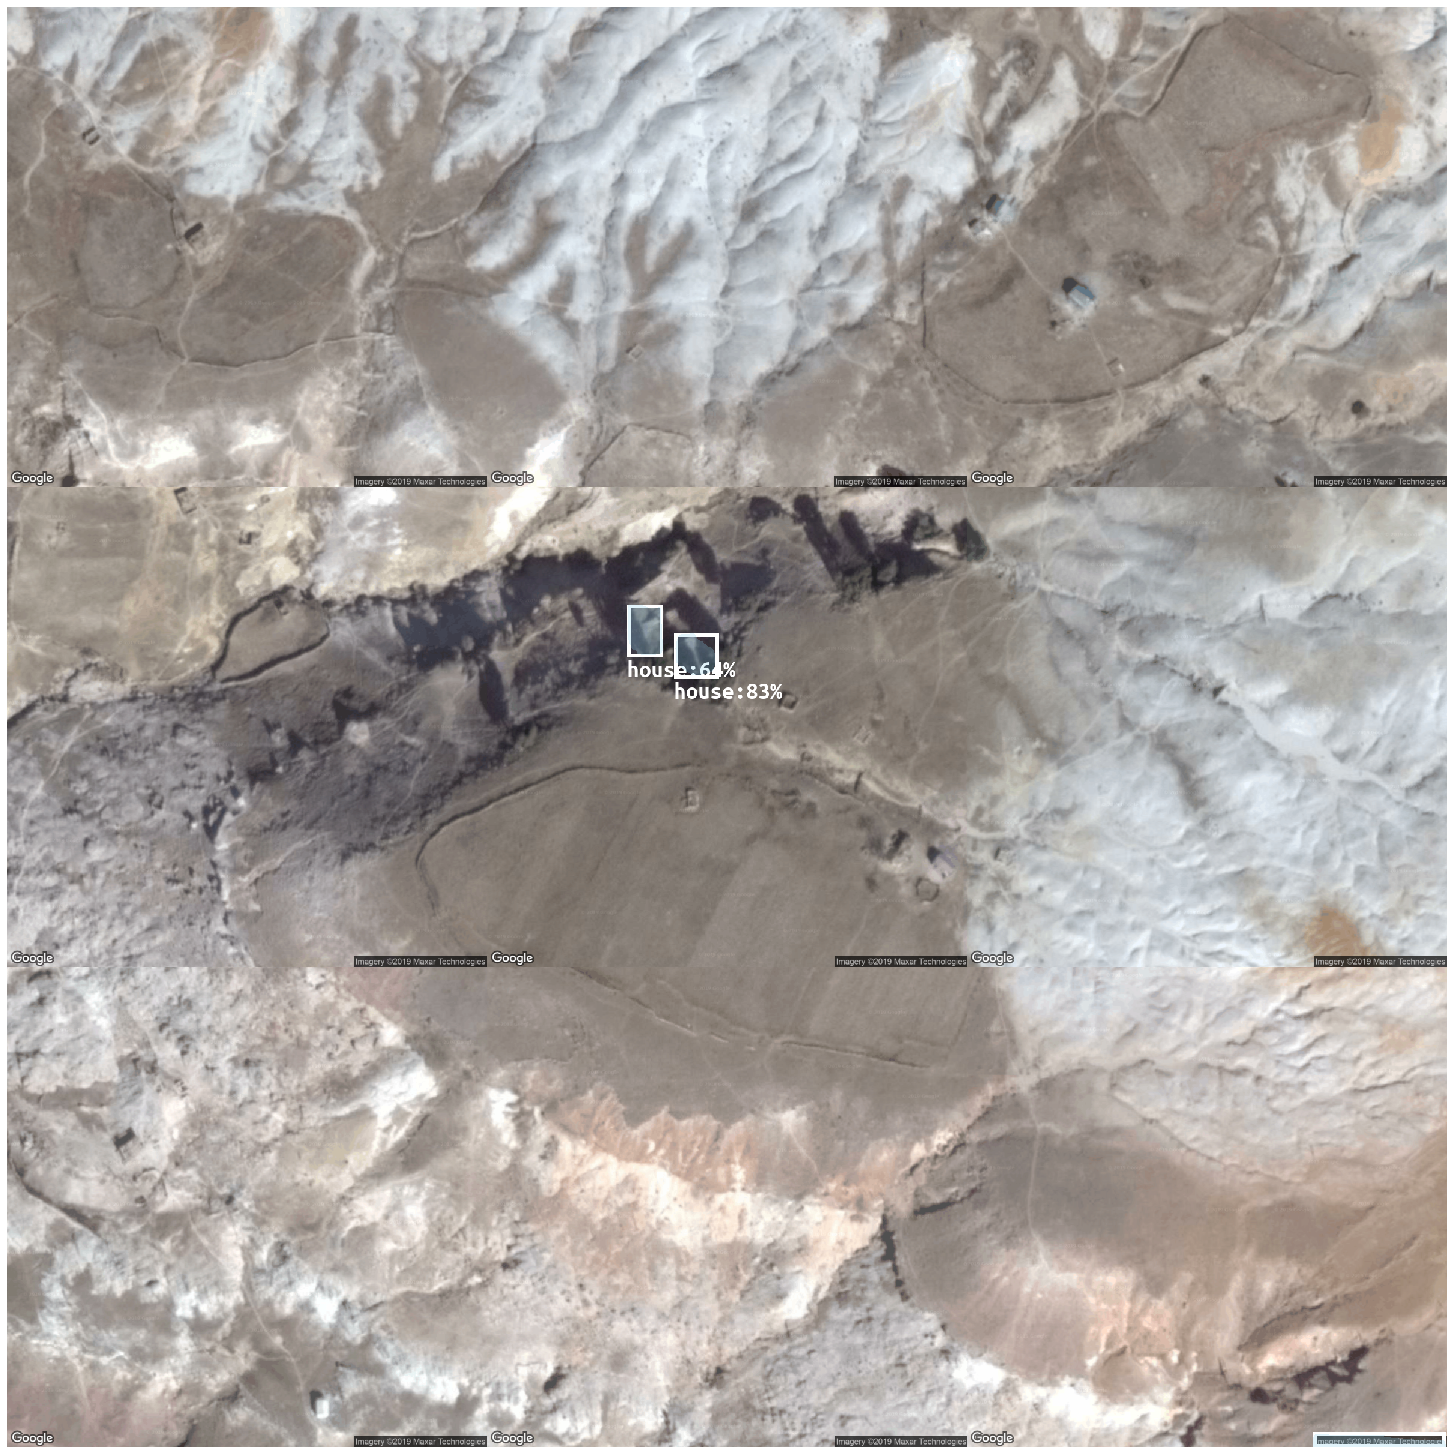

In [22]:
# randomly sample one chip
ent, mun, loc = df.sample(n=1).index.values[0]
# show merged data frame
df_sampled = df.loc[(ent, mun, loc), :].agg(
    {'pop': 'mean',
     'inhabited_houses': 'mean',
     'houses': 'mean',
     'score': 'count'})
# show inference image
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(20, 20))
fig.subplots_adjust(hspace=0, wspace=0,
                    right=1, bottom=0, left=0, top=1)
for i in range(3):
    for j in range(3):
        chip_id = j * 3 + (2 - i)
        im = plt.imread(os.path.join(
            VIZ_DIR,
            'ENT{:02d}MUN{:03d}LOC{:04d}CHIP{:02d}.png'
            .format(ent, mun, loc, chip_id)))
        ax[i, j].imshow(im)
        ax[i, j].axis('off')
fig.savefig(os.path.join(
    OUT_DIR, 'ENT{:02d}MUN{:03d}LOC{:04d}CEN{:03d}SAT{:03d}.png'
             .format(ent, mun, loc,
                     int(df_sampled['houses']),
                     int(df_sampled['score']))))

In [16]:
df_group = df.groupby(['ent', 'mun', 'loc']).agg(
    cen_pop=pd.NamedAgg(column='pop', aggfunc='mean'),
    cen_house=pd.NamedAgg(column='houses', aggfunc='mean'),
    cen_inhab=pd.NamedAgg(column='inhabited_houses', aggfunc='mean'),
    sat_house=pd.NamedAgg(column='score', aggfunc='count'))

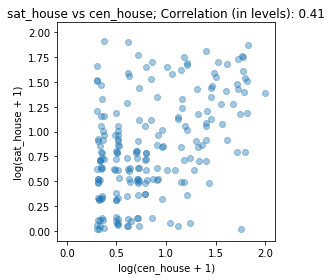

In [17]:
# plotting begins
plot_scatter('cen_house', 'sat_house', lims=(-0.1, 2.1))